In [1]:
import pandas as pd
import utils

In [2]:
# Load this data, which contains a currated collection of features from ADNI
dfADNI = pd.read_csv('../data/adni/ADNIMERGE.csv')
dfADNI['Visit_Month'] = dfADNI['VISCODE'].apply(lambda x: utils.dictVisit2Months[x])

In [14]:
dfADNI.index = pd.MultiIndex.from_frame(dfADNI[['PTID', 'Visit_Month']])
dfADNI = dfADNI.loc[~dfADNI.index.duplicated(keep='first')]
dfADNI = dfADNI.sort_index()
# Fill in missing diagnoses, IF the diagnoses at the preceding and subsequent visits are the same
dfADNI['DX'].loc[dfADNI['DX'].shift(-1) == dfADNI['DX'].shift(1)] = dfADNI['DX'].shift(1)

print(dfADNI.shape[0], 'samples in ADNI')
# Limit to subjects with MCI
dfMCI = dfADNI.loc[dfADNI['DX'] == 'MCI']
dfMCI.index = pd.MultiIndex.from_frame(dfMCI[['PTID', 'Visit_Month']])
print(dfMCI.shape[0], 'samples with MCI')


14944 samples in ADNI
5893 samples with MCI


In [15]:
# For each sample, check for conversion to AD at various timepoints
subjects = dfMCI['PTID'].unique()
subjects.sort()
print(subjects.shape[0], 'unique subjects with MCI at baseline')
dfConversion = pd.DataFrame(index=dfMCI.index)

for nMonths in [6, 12, 18, 24, 30, 36, 42, 48]:
    lsConversion = []
    for strID, nVisit in dfConversion.index:
        if (strID, nVisit + nMonths) in dfADNI.index:
            # check if DX is available at exactly this time interval
            lsConversion += [dfADNI['DX'].loc[(strID, nVisit + nMonths)] == 'Dementia']
        else:
            # Check the nearest visits before and after this timepoint
            dfVisits = dfADNI['DX'].loc[strID]
            dfVisits = dfVisits.sort_index()
            dfNextVisits = dfVisits.loc[dfVisits.index > (nVisit + nMonths)]
            dfPrevVisits = dfVisits.loc[dfVisits.index < (nVisit + nMonths)]
            if dfPrevVisits.shape[0] > 0:
                # If they had already converted, mark as converted at this timepoint
                if dfPrevVisits.iloc[-1] == 'Dementia':
                    lsConversion += [True]
                    continue
                # Otherwise, check future visits
            if dfNextVisits.shape[0] > 0:
                # If they haven't converted in the next visit, mark as non-converted
                if dfNextVisits.iloc[0] != 'Dementia':
                    lsConversion += [False]
                    continue
                # Otherwise, conversion status is unknown
            lsConversion += ['unknown']

    dfConversion[nMonths] = lsConversion


1150 unique subjects with MCI at baseline


In [16]:
# Make sure that when conversion occurs, it is propagated across all subsequent timepoints. There may be some NaN values remaining that cause a False to appear after someone has already converted at a previous timepoint.
for idx, row in dfConversion.iterrows():
    if True in row.values:
        lastTrue = row.index[row == True].values[-1]
        row.loc[row.index > lastTrue] = True

# Drop rows with all unknowns
dfConversion = dfConversion.loc[~(dfConversion == 'unknown').all(axis=1)]
print(dfConversion.shape[0], 'samples with conversion status available at any timepoint')



5220 samples with conversion status available at any timepoint


Text(0, 0.5, 'Count')

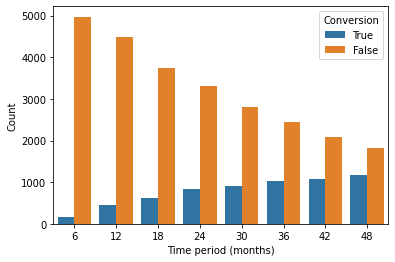

In [17]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
dfLong = dfConversion.melt(var_name='Time period (months)', value_name='Conversion')
sns.countplot(data=dfLong, x='Time period (months)', hue='Conversion', hue_order=[True, False])
plt.ylabel('Count')


In [35]:
# Add column for study
dfConversion['Study'] = dfADNI['COLPROT'].loc[dfConversion.index]
dfConversion.iloc[200:210]

6     12       18       24       30       36  \
PTID       Visit_Month                                                     
003_S_4354 24           False  False    False    False    False    False   
           36           False  False    False    False    False    False   
           48           False  False    False    False    False    False   
           60           False  False    False    False  unknown  unknown   
003_S_6258 0            False  False  unknown  unknown  unknown  unknown   
003_S_6268 0            False  False  unknown  unknown  unknown  unknown   
003_S_6432 0            False  False  unknown  unknown  unknown  unknown   
003_S_6479 0            False  False  unknown  unknown  unknown  unknown   
003_S_6606 0            False  False  unknown  unknown  unknown  unknown   
005_S_0222 0            False   True     True     True     True     True   

                             42       48  Study  
PTID       Visit_Month                           
003_S_4354 24             False    False  ADNI2  
           36             False    False  ADNI2  
           48           unknown  unknown  ADNI2  
           60           unknown  unknown  ADNI3  
003_S_6258 0            unknown  unknown  ADNI3  
003_S_6268 0            unknown  unknown  ADNI3  
003_S_6432 0            unknown  unknown  ADNI3  
003_S_6479 0            unknown  unknown  ADNI3  
003_S_6606 0            unknown  unknown  ADNI3  
005_S_0222 0               True     True  ADNI1

Text(0, 0.5, 'Samples')

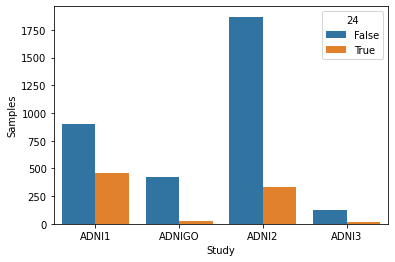

In [34]:
df24 = dfConversion[[24, 'Study']]
df24 = df24.loc[df24[24] != 'unknown']
sns.countplot(data=df24, x='Study', hue=24, orient='h')
plt.ylabel('Samples')

In [36]:
# Save data to file
dfConversion.to_csv('conversion_by_month.csv')
dfADNI.loc[dfConversion.index].to_csv('adnimerge_mci.csv')